In [1]:
import numpy as np
import os
import random
import torch
from configs.configs import Configs
from models.predictor_model import EssayScorer
from transformers import AutoConfig
from utils.create_embedding_feautres import create_embedding_features
from utils.dvrl_utils import remove_top_p_sample, fit_func, pred_func, calc_qwk, random_remove_sample
from sklearn.metrics import mean_squared_error

/Users/takumishibata/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load data from data/train_dev_test_split/1/fold-0/...
Loading embedding from cache...
X_train:  (1071, 1024)
Y_train:  (1071,)
Y_train max:  1.0
Y_train min:  0.0
X_dev:  (356, 1024)
Y_dev:  (356,)
Y_dev max:  1.0
Y_dev min:  0.1
X_test:  (356, 1024)
Y_test:  (356,)
Y_test max:  1.0
Y_test min:  0.0
Creating predictor model...
y_true:  [ 6.  8.  8.  8. 11.  7.  8.  8.  8.  8. 10.  7.  6. 10.  8.  8.  7.  8.
  8.  8.  9.  8.  8.  6.  9. 12. 12.  6.  7.  9.  7.  9. 12.  8. 10.  9.
 10.  9.  8.  8. 10. 10.  9.  8. 10.  8.  7. 10. 11.  7.  9.  8.  8.  9.
  9.  8.  8.  6. 10. 11.  8.  7. 11.  5.  8. 11. 11.  8. 11.  7. 10. 11.
 10.  8.  8.  8.  8.  6.  9.  7.  6.  6.  8.  8.  8.  4.  8. 11. 10.  8.
 10. 10.  9.  8.  8. 12.  8. 10.  7.  9. 10.  8.  8.  8.  8. 10.  6.  6.
  8.  9. 10.  6.  9.  4.  8. 10. 10. 10.  8.  8.  9.  8.  8. 11. 10.  4.
  7.  3. 10.  9.  8.  8.  8.  8.  8.  9.  9.  9. 10.  9.  8. 10.  8.  8.
  9.  4.  8.  8. 10.  8.  8. 10. 10. 11. 12.  4. 11.  8.  8.  9.  7.  9.
  8. 

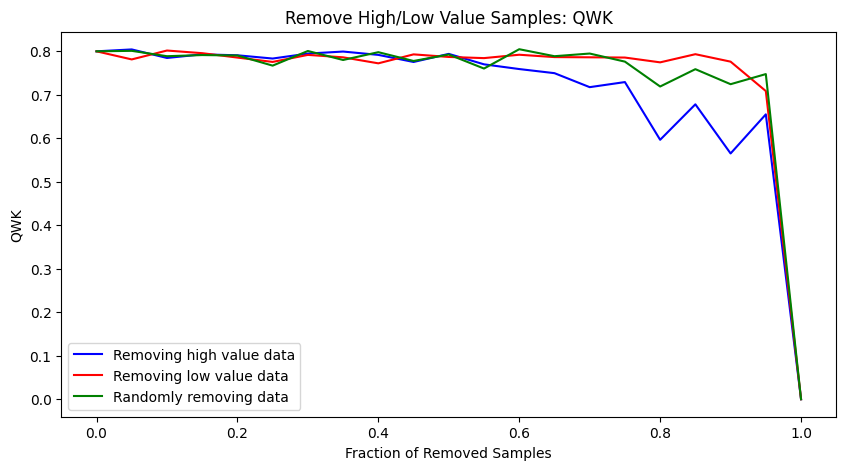

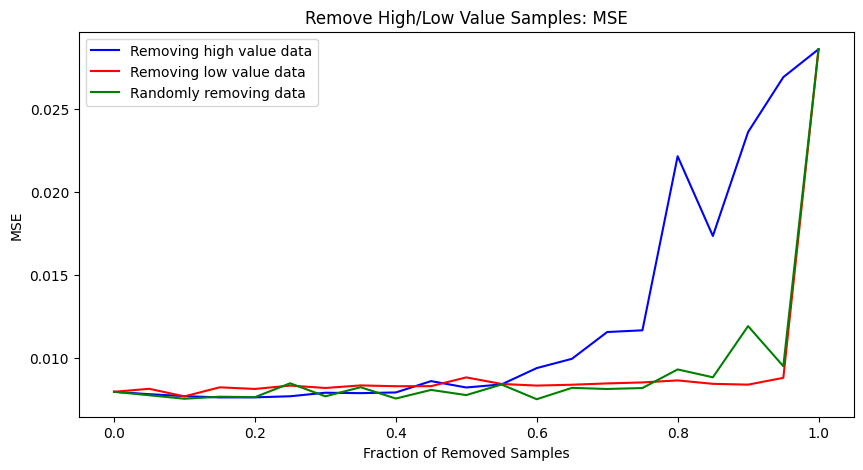

In [3]:
test_prompt_id = 1
output_path = f'outputs/DVRL_DataValueEstimate{test_prompt_id}/'

seed = 12
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
configs = Configs()
attribute_name = 'score'

# Load data
data_path = configs.DATA_PATH2 + str(test_prompt_id) + '/fold-0/'
model_name = 'microsoft/deberta-v3-large'

train_features, dev_features, test_features, y_train, y_dev, y_test = create_embedding_features(data_path, test_prompt_id, attribute_name, model_name, device)

# print info
print('================================')
print('X_train: ', train_features.shape)
print('Y_train: ', y_train.shape)
print('Y_train max: ', np.max(y_train))
print('Y_train min: ', np.min(y_train))

print('================================')
print('X_dev: ', dev_features.shape)
print('Y_dev: ', y_dev.shape)
print('Y_dev max: ', np.max(y_dev))
print('Y_dev min: ', np.min(y_dev))

print('================================')
print('X_test: ', test_features.shape)
print('Y_test: ', y_test.shape)
print('Y_test max: ', np.max(y_test))
print('Y_test min: ', np.min(y_test))
print('================================')

# Remove high and low value samples
low_qwks = []
low_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p, ascending=True)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, dev_features, batch_size=256, device=device)
    qwk = calc_qwk(y_dev, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_dev, y_pred)
    print(f'QWK: {qwk:.4f}')
    low_qwks.append(qwk)
    low_mse.append(mse)

np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

high_qwks = []
high_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p, ascending=False)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, dev_features, batch_size=256, device=device)
    qwk = calc_qwk(y_dev, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_dev, y_pred)
    print(f'QWK: {qwk:.4f}')
    high_qwks.append(qwk)
    high_mse.append(mse)


np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

random_qwks = []
random_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = random_remove_sample(np.load(output_path + 'estimated_data_value.npy'), remove_p=p)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, dev_features, batch_size=256, device=device)
    qwk = calc_qwk(y_dev, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_dev, y_pred)
    print(f'QWK: {qwk:.4f}')
    random_qwks.append(qwk)
    random_mse.append(mse)

import matplotlib.pyplot as plt
# plot
p = np.arange(0.0, 1.01, 0.05)
plt.figure(figsize=(10, 5))
plt.plot(p, high_qwks, label='Removing high value data', color='blue')
plt.plot(p, low_qwks, label='Removing low value data', color='red')
plt.plot(p, random_qwks, label='Randomly removing data', color='green')
plt.title('Remove High/Low Value Samples: QWK')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('QWK')
plt.legend()
plt.savefig(output_path + 'remove_high_low_value_samples_qwk.png')


plt.figure(figsize=(10, 5))
plt.plot(p, high_mse, label='Removing high value data', color='blue')
plt.plot(p, low_mse, label='Removing low value data', color='red')
plt.plot(p, random_mse, label='Randomly removing data', color='green')
plt.title('Remove High/Low Value Samples: MSE')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('MSE')
plt.legend()
plt.savefig(output_path + 'remove_high_low_value_samples_mse.png')